# **Question And Answering Project using LLM BERT**

## **Install Necessary Libraries**

In [3]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## **Import Libraries and Load Dataset**

In [22]:
from datasets import load_dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
# Load the SQuAD dataset
dataset = load_dataset("squad")
# Select only 1000 samples from the training and validation sets for quick testing
train_subset = dataset["train"].shuffle(seed=42).select([i for i in range(1000)])
val_subset = dataset["validation"].shuffle(seed=42).select([i for i in range(100)])

# Update dataset to contain only these subsets
dataset = {"train": train_subset, "validation": val_subset}

## **Load Pre-trained Model and Tokenizer**

In [23]:
# Load pre-trained model and tokenizer
model_name = "bert-base-uncased"
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Define Training Arguments**

In [26]:
# Step 6: Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=250,  # Evaluate every 250 steps
    logging_dir="./logs",
    logging_steps=10,  # Log every 10 steps
    learning_rate=2e-5,
    per_device_train_batch_size=4,  # Reduced batch size for testing
    per_device_eval_batch_size=4,   # Reduced batch size for evaluation
    num_train_epochs=1,  # Reduced epochs for testing
    weight_decay=0.01,
    gradient_accumulation_steps=8,  # Accumulate gradients over 8 steps
    fp16=True,  # Enable mixed precision training (use GPU if available)
    save_steps=1000,  # Save model checkpoints every 1000 steps
    save_total_limit=2,  # Limit the number of saved checkpoints
    report_to="none",  # Disable reporting to external systems
)

## **Preprocess the Data**

In [27]:
# Step 3: Preprocess the data by tokenizing and preparing start/end positions
def preprocess_function(examples):
    # Tokenize the inputs
    inputs = tokenizer(
        examples["question"],
        examples["context"],
        truncation=True,
        padding="max_length",
        max_length=384
    )

    start_positions = []
    end_positions = []

    for i in range(len(examples["context"])):
        answer = examples["answers"][i]
        start_pos = answer["answer_start"][0]
        end_pos = start_pos + len(answer["text"][0])

        # Ensure that the start and end positions are within the maximum length
        start_positions.append(min(start_pos, 383))
        end_positions.append(min(end_pos, 383))

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

# Step 4: Tokenize the datasets and apply the preprocessing function to each split
train_tokenized = train_subset.map(preprocess_function, batched=True)
val_tokenized = val_subset.map(preprocess_function, batched=True)

# Step 5: Set up the data collator to pad the inputs during batching
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

## **Create Trainer and Train the Model**

In [29]:
# Step 7: Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,  # Provide tokenizer to Trainer
    data_collator=data_collator,  # Provide data collator
)

<ipython-input-29-38005abbe95a>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=31, training_loss=5.918512021341631, metrics={'train_runtime': 3897.3287, 'train_samples_per_second': 0.257, 'train_steps_per_second': 0.008, 'total_flos': 194404787011584.0, 'train_loss': 5.918512021341631, 'epoch': 0.992})

In [56]:
# save the model

trainer.save_model("./results")  # Save the model to the specified directory


## **Evaluate the Model**

In [31]:
# Evaluate the model
trainer.evaluate()


{'eval_loss': 5.849552154541016,
 'eval_runtime': 119.0115,
 'eval_samples_per_second': 0.84,
 'eval_steps_per_second': 0.21,
 'epoch': 0.992}

## **Make Predictions**

In [57]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

# Load the trained model and tokenizer
model_name = "./results"  # Path to the directory where the model is saved
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Use the same tokenizer used during training

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the context and question
context = "The Great Wall of China is an ancient series of walls and fortifications located in northern China. It was built to protect Chinese states and empires against the raids and invasions of the nomadic groups of the Eurasian Steppe."
question = "Why was the Great Wall of China built?"

# Tokenize the input
inputs = tokenizer(question, context, return_tensors="pt").to(device)

# Get the model outputs
with torch.no_grad():  # Disable gradient calculation during inference
    outputs = model(**inputs)

# Get the start and end logits
start_logits = outputs.start_logits
end_logits = outputs.end_logits

# Convert logits to probabilities (softmax)
start_probs = torch.softmax(start_logits, dim=-1)
end_probs = torch.softmax(end_logits, dim=-1)

# Initialize variables to store the best start and end positions
best_start, best_end = 0, 0
max_prob = 0

# Loop through the start and end probabilities to find the best span
for start in range(len(start_probs[0])):
    for end in range(start, min(start + 30, len(end_probs[0]))):  # Limit span length to 30
        prob = start_probs[0][start] * end_probs[0][end]
        if prob > max_prob:
            best_start, best_end = start, end
            max_prob = prob

# Extract the most likely answer span
answer_tokens = inputs.input_ids[0][best_start:best_end + 1].tolist()
answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)

# Display the result
print(f"Question: {question}")
print(f"Answer: {answer}")


Question: Why was the Great Wall of China built?
Answer: walls and fortifications located in northern china. it was built to protect chinese states and empires against the raids and invasions of the nomadic groups


# **Visualizations**

## **Training loss, Evaluation loss**

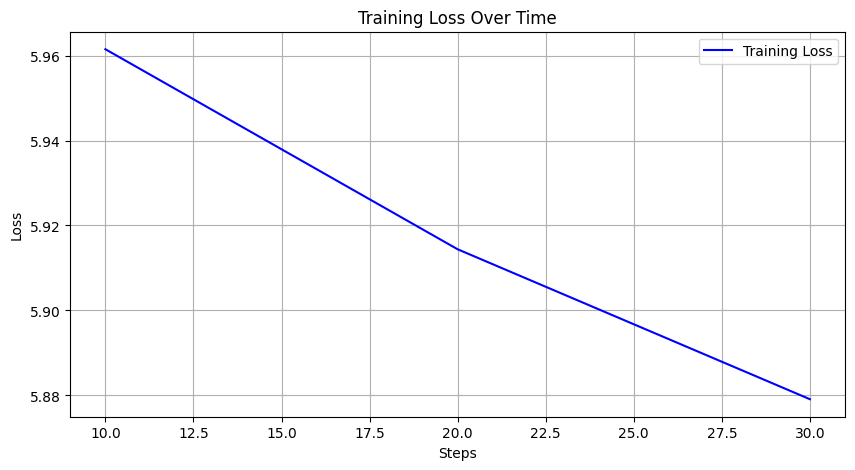

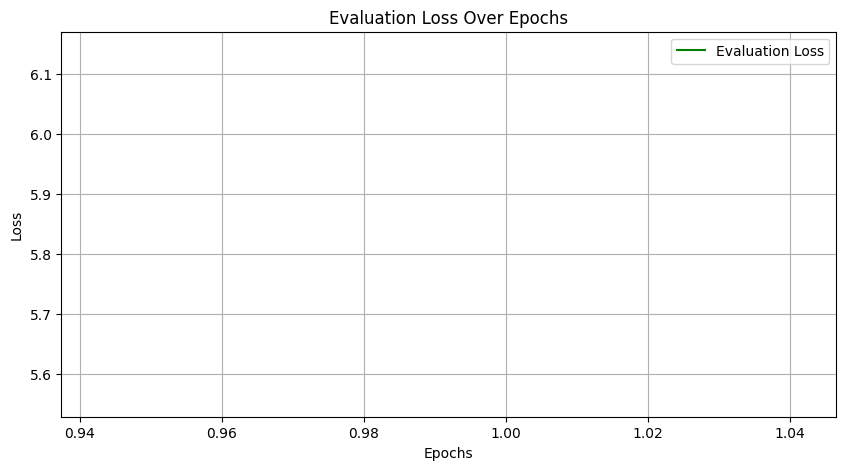

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training logs from trainer object (assuming 'trainer.state.log_history' is available)
log_history = trainer.state.log_history

# Convert logs to a DataFrame
log_df = pd.DataFrame(log_history)

# Filter rows with non-null 'step' and 'loss' for training loss plot
training_loss_df = log_df[log_df['step'].notnull() & log_df['loss'].notnull()]

# Plot training loss over steps
plt.figure(figsize=(10, 5))
plt.plot(training_loss_df['step'], training_loss_df['loss'], label="Training Loss", color="blue")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Filter rows with non-null 'epoch' and 'eval_loss' for evaluation loss plot
eval_loss_df = log_df[log_df['epoch'].notnull() & log_df['eval_loss'].notnull()]

# Plot evaluation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(eval_loss_df['epoch'], eval_loss_df['eval_loss'], label="Evaluation Loss", color="green")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Evaluation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Check if evaluation metrics like 'eval_exact_match' and 'eval_f1' are available
if 'eval_exact_match' in log_df.columns and 'eval_f1' in log_df.columns:
    eval_metrics_df = log_df[log_df['epoch'].notnull() & log_df['eval_exact_match'].notnull() & log_df['eval_f1'].notnull()]

    # Plot Exact Match score over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(eval_metrics_df['epoch'], eval_metrics_df['eval_exact_match'], label="Exact Match", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Exact Match Score")
    plt.title("Exact Match Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot F1 Score over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(eval_metrics_df['epoch'], eval_metrics_df['eval_f1'], label="F1 Score", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


## **Learning Rate Plot**

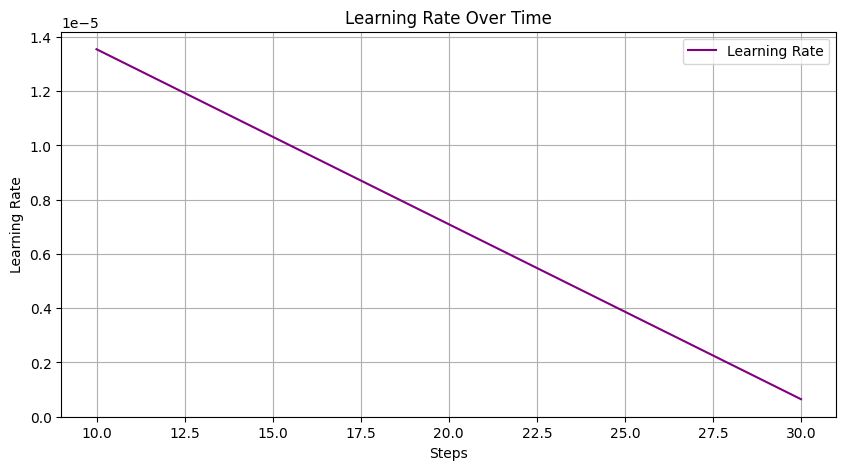

In [62]:
# Check if 'learning_rate' is available in log_df
if 'learning_rate' in log_df.columns:
    learning_rate_df = log_df[log_df['step'].notnull() & log_df['learning_rate'].notnull()]

    # Plot Learning Rate over Steps
    plt.figure(figsize=(10, 5))
    plt.plot(learning_rate_df['step'], learning_rate_df['learning_rate'], label="Learning Rate", color="purple")
    plt.xlabel("Steps")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


## **Histogram of Training Loss**

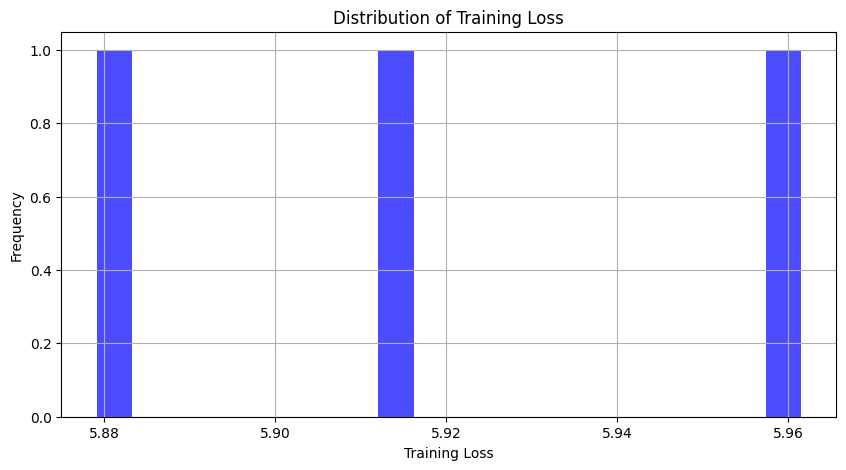

In [66]:
# Plot histogram of training loss values
plt.figure(figsize=(10, 5))
plt.hist(training_loss_df['loss'], bins=20, alpha=0.7, color='blue')
plt.xlabel("Training Loss")
plt.ylabel("Frequency")
plt.title("Distribution of Training Loss")
plt.grid(True)
plt.show()


## **Answer Span Visualization**

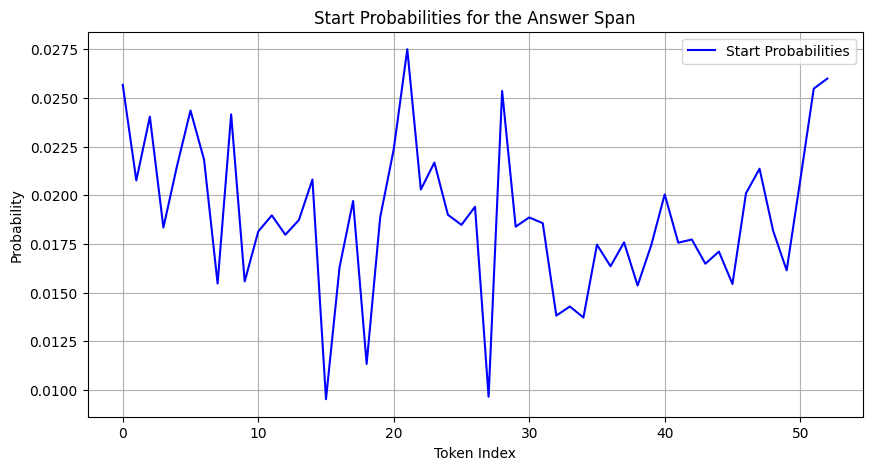

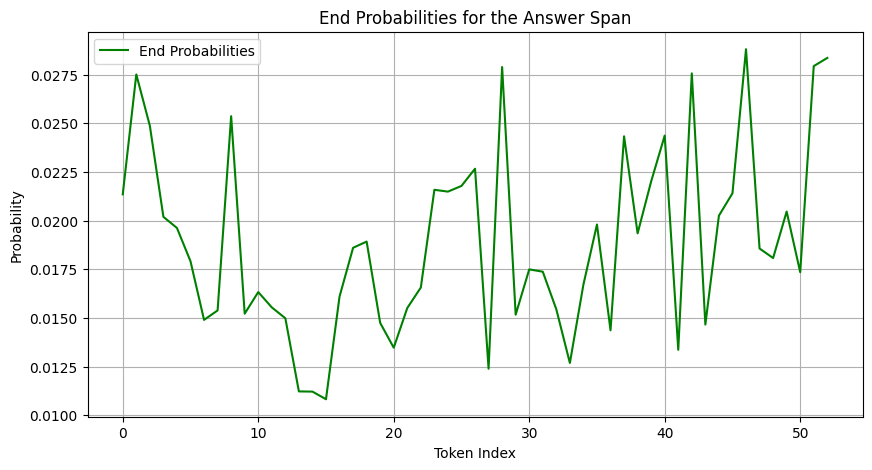

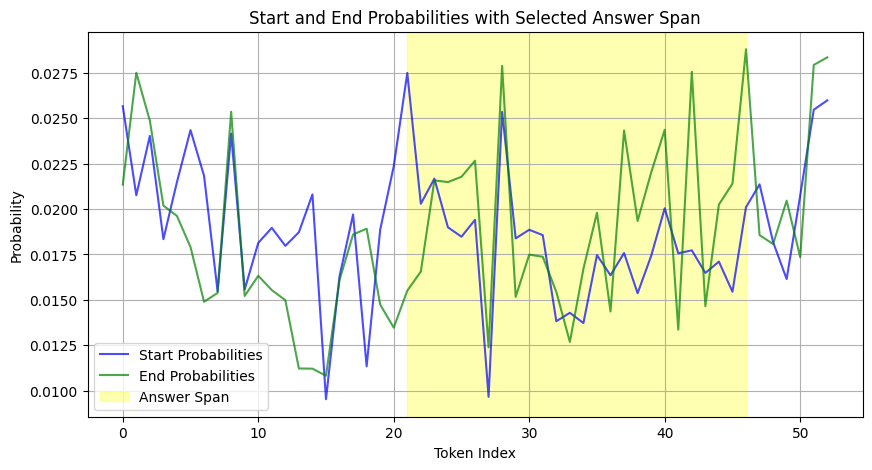

Answer Span (Tokens): ['walls', 'and', 'fortifications', 'located', 'in', 'northern', 'china', '.', 'it', 'was', 'built', 'to', 'protect', 'chinese', 'states', 'and', 'empires', 'against', 'the', 'raids', 'and', 'invasions', 'of', 'the', 'nomadic', 'groups']


In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the probabilities to numpy arrays for easy plotting
start_probs_np = start_probs[0].cpu().numpy()
end_probs_np = end_probs[0].cpu().numpy()

# Visualize the Start Probabilities
plt.figure(figsize=(10, 5))
plt.plot(start_probs_np, label="Start Probabilities", color='blue')
plt.title("Start Probabilities for the Answer Span")
plt.xlabel("Token Index")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.show()

# Visualize the End Probabilities
plt.figure(figsize=(10, 5))
plt.plot(end_probs_np, label="End Probabilities", color='green')
plt.title("End Probabilities for the Answer Span")
plt.xlabel("Token Index")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.show()

# Visualizing the Answer Span Selection
# Highlight the answer span in the token list
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

# Mark the span of the answer
answer_span_tokens = tokens[best_start:best_end + 1]

# Plot the start and end probability distributions alongside the tokens
plt.figure(figsize=(10, 5))
plt.plot(start_probs_np, label="Start Probabilities", color='blue', alpha=0.7)
plt.plot(end_probs_np, label="End Probabilities", color='green', alpha=0.7)

# Highlight the selected answer span
plt.axvspan(best_start, best_end, color='yellow', alpha=0.3, label="Answer Span")

plt.title("Start and End Probabilities with Selected Answer Span")
plt.xlabel("Token Index")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.show()

# Print the selected answer span (tokens)
print(f"Answer Span (Tokens): {answer_span_tokens}")
